# Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

import fidimag
import sim_from_image as sfi
import os, re
import fidimag.common.constant as C
from fidimag.atomistic import UniformExchange, DMI, Anisotropy, DemagHexagonal
from fidimag.atomistic import Zeeman

import colorsys
from cycler import cycler

from mpl_toolkits.axes_grid.inset_locator import inset_axes
import mpl_toolkits.axisartist as AA
import nebm_plot_tools.npt_colormaps as npt_cm

import string

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/david/anaconda3/lib/python3.6/site-packages/nebm_plot_tools/nebm_plot_tools.py:14: UserWarning: The Energy scale is in Joules. If you want to use a different energy scale, you can redefine the neb_plot_functions.scale variable and, to change the labels, use the neb_plot_functions.scale_label variable. In this way, the energy data will be divided by *scale*, e.g. 
 import nebm_plot_tools as npt 
npt.scale = 1000 
npt.scale_label = 'kJ' 
  warnings.warn(imp_message)


In [2]:
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

# Functions

In [3]:
plt.style.use('lato_style.mplstyle')

# -----------------------------------------------------------------------------

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) / 255.
                 for i in range(0, lv, lv // 3))

# -----------------------------------------------------------------------------

# Colour palettes for the curves (used in cycle
d_palette2 = ['29376E', 'F52A00', 'F79400', '245723', 'DE2600']
d_palette1 = ['2C4C8F', '000000', '00802b', 'D91D2C', '8F5536',
              '542437', '6F6F6F']

# Turn it into a palette readable by matplotlib
d_palette2 = [hex_to_rgb(c) for c in d_palette2]
d_palette1 = [hex_to_rgb(c) for c in d_palette1]

In [4]:
def load_energy_relaxation(sim, B, npy_path):
    """
    Given a simulation object, a field B in Tesla and a Numpy file
    with the magnetisation field (or a valid Fidimag input), returns the
    
        energy, dmi_energy, exch energy, anisotropy energy, Q charge
    """
    
    # if compute_Q:
    #     Q = []
    
    if isinstance(npy_path, str):
        sim.set_m(np.load(npy_path))
    else:
        sim.set_m(npy_path)
    
    # m_data = np.copy(sim.spin.reshape(-1, 3))
    sim.get_interaction('Zeeman').update_field([0., 0., B])
    
    sim.compute_effective_field(t=0)
    sim.compute_energy()
    dmi_data = np.copy(sim.get_interaction('DMI').compute_energy())
    exchange_data = np.copy(sim.get_interaction('UniformExchange').compute_energy())
    anisotropy_data = np.copy(sim.get_interaction('Anisotropy').compute_energy())
    zeeman_data = np.copy(sim.get_interaction('Zeeman').compute_energy())
    
    Q = sim.skyrmion_number(method='BergLuscher')
    
    # if compute_Q:
    #     return dmi_data, exchange_data, Q

    return sim.compute_energy(), dmi_data, exchange_data, anisotropy_data, zeeman_data, Q


def load_magnetisation_relaxation(sim, B, npy_path, comp='z'):
    cs = {'x': 0, 'y': 1, 'z': 2}
    m = []
    sim.set_m(np.load(npy_path))
    sim.get_interaction('Zeeman').update_field([0., 0., B])
    sim.compute_effective_field(t=0)
    sim.compute_energy()
    return np.copy(sim.spin.reshape(-1, 3))[:, cs[comp]]

In [5]:
def npy_state(state, B, base_folder='../simulations/relaxation/image_rotated_B-sweep_DT/npys/'):
    npy_folder_name = '2Dhex_image-rotated_PdFe-Ir_{}_B{}mT_npys'.format(state, B)
    npy_file = os.listdir(os.path.join(base_folder, npy_folder_name))[0]
    # print(npy_file)
    return os.path.join(base_folder, npy_folder_name, npy_file)

# Simulation object

In [6]:
mu_s = 'mu_s/Pd_Fe_Ir111_20160118_CrTip_015_B-4T_003_rotated_large_bw_mus3-muB.npy'
sim_from_image = sfi.sim_from_image(
    ('Romming_data/Pd_Fe_Ir111_configurations/gimp/png/000.png'),
    image_range=[0, 21.03, 0, 17.79],
    sim_name="rotated_exp_hexagon"
    )
sim_from_image.generate_magnetic_moments(load_file=mu_s)
sim = sim_from_image.sim
mask = (sim.mu_s / C.mu_B) > 1e-5
exch = UniformExchange(5.881 * C.meV)
sim.add(exch)
dmi = DMI(D=1.557 * C.meV, dmi_type='interfacial')
sim.add(dmi)
sim.add(Zeeman([0., 0., 0.]))
sim.add(Anisotropy(0.406 * C.meV, axis=[0, 0, 1]))

# Data

Load the field, total energy, energy from all the interactions, and topological charge for the different configurations in a dictionary:

In [7]:
states = {'1-sk-down': [], '3-sk-down': [], 'tgt-st-up': [], 'fm-up':[], 'tgt-st-up-3PI':[], 'helicoid-x-4nm': []}

for s in states.keys():
    for B in range(0, 2501, 100):
        total_energy, dmi, exchange, anisotropy, zeeman, Q = load_energy_relaxation(sim, B * 1e-3, npy_state(s, B))
        states[s].append([B * 1e-3, total_energy, dmi, exchange, anisotropy, zeeman,
                          Q])
        
# Fully saturated state
sat_up = []
for B in range(0, 2501, 100):
    total_energy, dmi, exchange, anisotropy, zeeman, Q = load_energy_relaxation(sim, B * 1e-3, (0, 0, 1))
    print(B, total_energy / C.eV)

    sat_up.append([B * 1e-3, total_energy, dmi, exchange, anisotropy, zeeman, Q])

0 -79.97738199999998
100 -80.05568143909534
200 -80.13398087819068
300 -80.21228031728606
400 -80.29057975638142
500 -80.36887919547678
600 -80.44717863457213
700 -80.5254780736675
800 -80.60377751276286
900 -80.6820769518582
1000 -80.76037639095357
1100 -80.83867583004894
1200 -80.91697526914429
1300 -80.99527470823965
1400 -81.07357414733501
1500 -81.15187358643037
1600 -81.23017302552573
1700 -81.30847246462109
1800 -81.38677190371645
1900 -81.46507134281181
2000 -81.54337078190717
2100 -81.62167022100253
2200 -81.69996966009788
2300 -81.77826909919325
2400 -81.85656853828861
2500 -81.93486797738396


# Plots

Here we plot starting up to the 5th element, i.e. up to 2.0 T:

Text(0,0.5,'$E -  E_{\\uparrow}\\,\\,\\mathrm{(eV)}$')

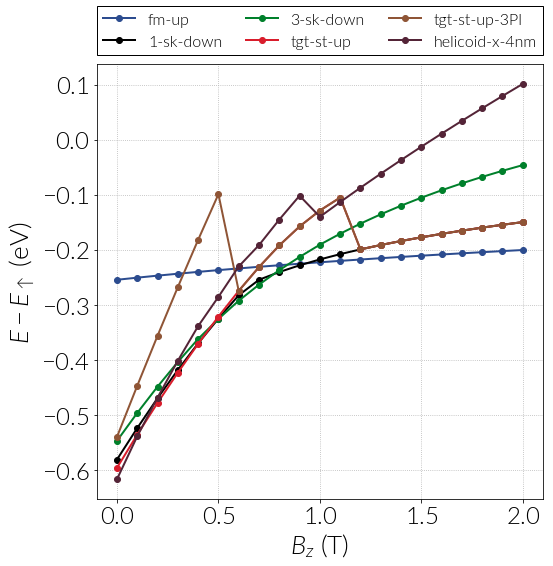

In [60]:
states_str = ['fm-up', '1-sk-down', '3-sk-down', 'tgt-st-up', 'tgt-st-up-3PI', 'helicoid-x-4nm']

f = plt.figure()
ax = f.add_subplot(111)
ax.set_prop_cycle(cycler('color', d_palette1))

for s in states_str:
    ax.plot(np.array(states[s])[:-5, 0], 
            (np.array(states[s])[:-5, 1] - np.array(sat_up)[:, 1][:-5]) / C.eV,
            'o-', label=s)

# plt.legend(fontsize=22)
ax.legend(ncol=3, loc='lower left',
          bbox_to_anchor=(0, 1.02, 1, 1),
          mode='expand', borderaxespad=0.,
          fontsize=16
          )

plt.grid(ls=':')

plt.xlabel(r'$B_{z}\,\,\mathrm{(T)}$')
plt.ylabel(r'$E -  E_{\uparrow}\,\,\mathrm{(eV)}$')

# plt.xlim([-1.2, 0])

# plt.savefig('image-rotated_hexagonal_island_PdFeIr111_total-energies.pdf', bbox_inches='tight')
# plt.savefig('image-rotated_hexagonal_island_PdFeIr111_total-energies_ALL.jpg',
#             density=200,
#             bbox_inches='tight')

# Spin field

Snapshots of the configurations at different fields which we are going to use in the energy plot. We get the data for  fields of 500 and 1500 mT:

In [8]:
spin_field = {'1-sk-down': [], '3-sk-down': [], 'tgt-st-up': [], 'fm-up':[], 'tgt-st-up-3PI':[], 'tgt-st-down-3PI':[], 'helicoid-x-4nm': []}

for s in spin_field.keys():
    # Fields:
    for B in [500, 1500]:
        spin_field[s].append(load_magnetisation_relaxation(sim, B * 1e-3, npy_state(s, B)))

Data at 500 mT:

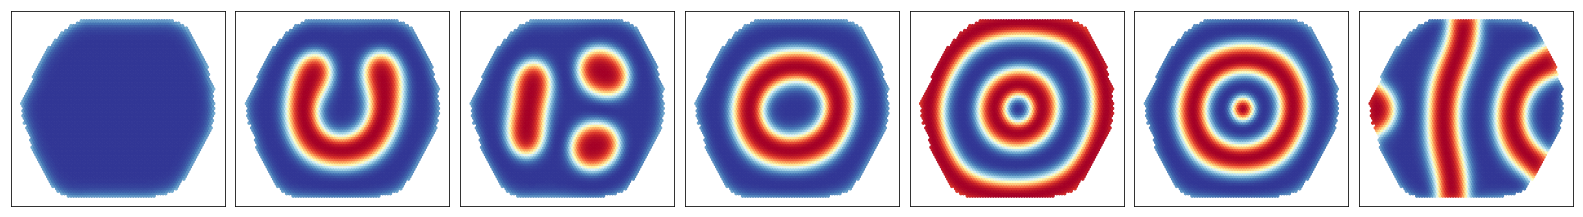

In [9]:
f, axs = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(28, 3.6))
for j, state in enumerate(['fm-up', '1-sk-down', '3-sk-down', 'tgt-st-up', 
                            'tgt-st-up-3PI', 'tgt-st-down-3PI', 'helicoid-x-4nm']):      
    ax = axs.flatten()[j]
    ax.scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=spin_field[state][0][mask], s=8, marker='h',
               cmap='RdYlBu', vmin=-1, vmax=1
                   )
    ax.set_xticks([])
    ax.set_yticks([])
f.subplots_adjust(hspace=0.1, wspace=0.05)

# plt.savefig('image-rotated_hexagonal_island_PdFeIr111_states_B0mT.jpg',
#             dpi=150, bbox_inches='tight')

Data at 1500 mT:

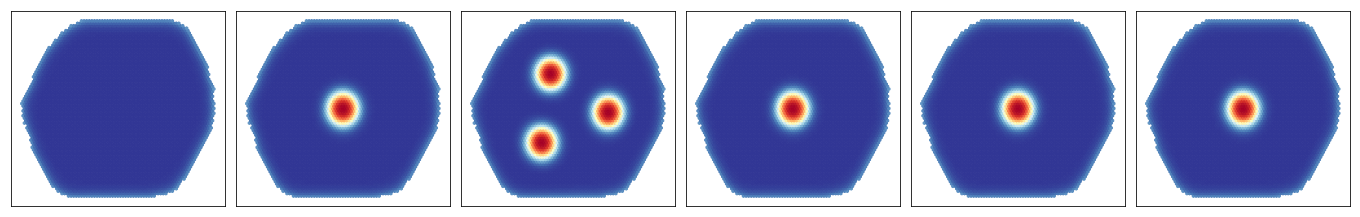

In [71]:
f, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(24, 3.6))
for j, state in enumerate(['fm-up', '1-sk-down', '3-sk-down', 'tgt-st-up', 
                            'tgt-st-up-3PI', 'tgt-st-down-3PI']):      
    ax = axs.flatten()[j]
    ax.scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=spin_field[state][1][mask], s=8, marker='h',
               cmap='RdYlBu', vmin=-1, vmax=1
                   )
    ax.set_xticks([])
    ax.set_yticks([])
f.subplots_adjust(hspace=0.1, wspace=0.05)
# plt.savefig('image-rotated_hexagonal_island_PdFeIr111_states_B-800mT.jpg',
#             dpi=150, bbox_inches='tight')

# Full energies

Here we make a plot showing all the energies and the topological charge. Snapshots are shown below the grid of energy plots:

In [66]:
island_ratio = np.max(sim.mesh.coordinates[:, 0]) / np.max(sim.mesh.coordinates[:, 1])
7 * island_ratio

8.225333791009913

In [67]:
island_ratio

1.1750476844299875

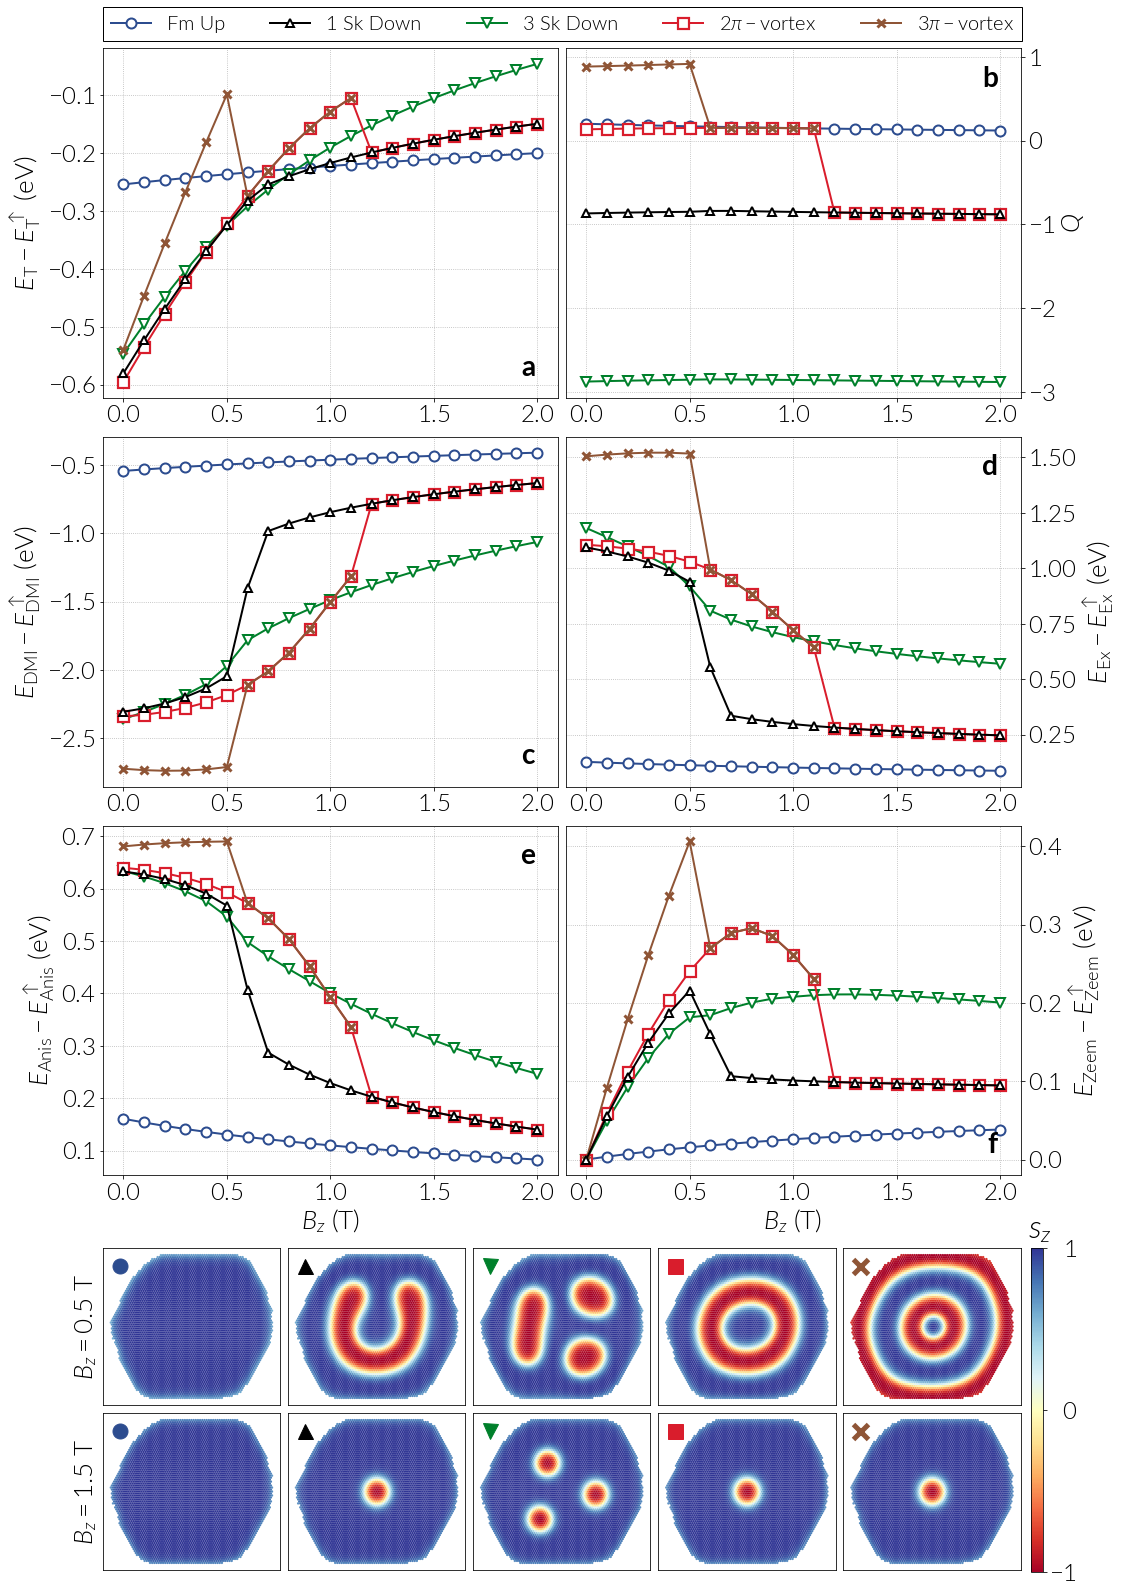

In [295]:
# Each plot has height = 7 (3 rows), the last row of plots has 3.5
f = plt.figure(figsize=(14 * island_ratio, 28))

axs = [None] * 16

# Make outer gridspec
# We will design a: 2 X 3 grid of plots, and add a 1 X 5 grid at the bottom
# The bottom plots have half the height of a  normal plot, so we set
# 2 + 2 + 2 + 1 in heights  -> 7:1 ratio
outer = gridspec.GridSpec(2, 1, height_ratios = [7, 2])
# Separation of the bottom row of plots from the top grid
outer.update(hspace=0.1)

# Make nested gridspecs
# gs2 will be used to plot snapshots of the five magnetic orderings
# We set 6 for the height of the 3 X 2 grid since each of these plots span
# 2 units of plots. We set the width as 20 since we divide gs2 in five, thus
# gs1 is divided in 10+10 (2 rows)
gs1 = gridspec.GridSpecFromSubplotSpec(6, 20, subplot_spec = outer[0], hspace=0.25)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 20, subplot_spec = outer[1], hspace=0.05)

# 3 X 2 grid of plots: heights span 2 units and widths span 10 units
axs[0] = plt.subplot(gs1[:2, :10])
axs[1] = plt.subplot(gs1[:2, 10:])
axs[2] = plt.subplot(gs1[2:4, :10])
axs[3] = plt.subplot(gs1[2:4, 10:])
axs[4] = plt.subplot(gs1[4:, :10])
axs[5] = plt.subplot(gs1[4:, 10:])

# 1 X 5 bottom row of plots: heights span 1 unit and widths 4 units
for j, i in enumerate(range(6, 11)):
    axs[i] = plt.subplot(gs2[:1, (j * 4):((j + 1) * 4)])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

for j, i in enumerate(range(11, 16)):
    axs[i] = plt.subplot(gs2[1:, (j * 4):((j + 1) * 4)])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

    
# -----------------------------------------------------------------------------

# Plot labels for the 3 X 2 grid of plots
labels = [r'$E_{\mathrm{T}} - E_{\mathrm{T}}^{\uparrow}\,\,\mathrm{(eV)}$',                # total energy
          r'$Q$',                                                                   # Q
          r'$E_{\mathrm{DMI}} - E_{\mathrm{DMI}}^{\uparrow}\,\,\mathrm{(eV)}$',   # DMI
          r'$E_{\mathrm{Ex}} - E_{\mathrm{Ex}}^{\uparrow}\,\,\mathrm{(eV)}$',     # Exchange
          r'$E_{\mathrm{Anis}} - E_{\mathrm{Anis}}^{\uparrow}\,\,\mathrm{(eV)}$', # Anisotropy
          r'$E_{\mathrm{Zeem}} - E_{\mathrm{Zeem}}^{\uparrow}\,\,\mathrm{(eV)}$'  # Zeeman
          ]

letter_labels = ['a', 'b', 'c', 'd', 'e', 'f']

# Every element of the states[] dictionary is a list with 6 elements:
# [total_E, Q_charge, DMI_E, exchange_E, anisotropy_E, Zeeman_E]
# We plot the topological charge Q (6th element) in the 2nd column of the 1st row
for j, i in enumerate([1, 6, 2, 3, 4, 5]):
    
    # We plot the energies with respect to the ferromagnetic state energy so
    # we substract the zero_st array from the data arrays
    # For Q, we set the zero_st as zeros since we don't need to rescale the
    # topological charge with respect to the FM state
    if i == 6:
        zero_st = np.zeros_like(np.array(states['fm-up'])[:, i])
        scale = 1.
    else:
        scale = C.eV
        zero_st = np.array(sat_up)[:, i] / scale
        
        
    ax = axs[j]

    ax.set_prop_cycle(cycler('color', d_palette1))

    # Plot the corresponding Q or energy for every magnetic ordering
    ax.plot(np.array(states['1-sk-down'])[:-5, 0], np.array(states['fm-up'])[:-5, i] / scale - zero_st[:-5],
            'o-', label='Fm Up', ms=10, mew=2, markerfacecolor='w')
    ax.plot(np.array(states['1-sk-down'])[:-5, 0], np.array(states['1-sk-down'])[:-5, i] / scale - zero_st[:-5],
            '^-', label='1 Sk Down', ms=8, zorder=5, markerfacecolor='w', mew=2)
    ax.plot(np.array(states['1-sk-down'])[:-5, 0], np.array(states['3-sk-down'])[:-5, i] / scale - zero_st[:-5],
            'v-', label='3 Sk Down', ms=10, mew=2, markerfacecolor='w')
    ax.plot(np.array(states['1-sk-down'])[:-5, 0], np.array(states['tgt-st-up'])[:-5, i] / scale - zero_st[:-5], 
            's-', label=r'$2\pi-\mathrm{vortex}$', markerfacecolor='w', ms=11, mew=2.2)
    # ax.plot(np.array(states['1-sk-up'])[:, 0][12:], np.array(states['helicoid'])[:, 1][12:] / C.meV - zero_st[12:], 'o-', label='Helicoid')
    ax.plot(np.array(states['1-sk-down'])[:, 0][:-14], np.array(states['tgt-st-up-3PI'])[:, i][:-14] / scale - zero_st[:-14], 
            'x-', ms=8, mew=3, label=r'$3\pi-\mathrm{vortex}$')


    ax.set_ylabel(labels[j])
    ax.grid(ls=':')

    # X label for the bottom plots
    if j > 3:
        ax.set_xlabel(r'$B_{z}\,\,\mathrm{(T)}$')

    # Legends at the top of the first plot
    if j == 0:
        ax.legend(ncol=5, loc='lower left',
          bbox_to_anchor=(0, 1.02, 2.02, 1),
          mode='expand', borderaxespad=0.,
          fontsize=20
          )
    
    # Right positioned label for the plots to the right
    if j == 1 or j == 3 or j == 5:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')

    # Alphabet labels to distinguish multiple plots
    if j in [1, 3, 4]:
        ax.text(0.95, 0.95, letter_labels[j], horizontalalignment='right',
                verticalalignment='top', transform=axs[j].transAxes, 
                fontsize=28, fontweight='bold')
    else:
        ax.text(0.95, 0.05, letter_labels[j], horizontalalignment='right',
                verticalalignment='bottom', transform=axs[j].transAxes, 
                fontsize=28, fontweight='bold')

    
        
# -----------------------------------------------------------------------------
# Snapshots for the bottom row of plots

marks = ['o', '^', 'v', 's', 'x']
for j, state in enumerate(['fm-up', '1-sk-down', '3-sk-down', 'tgt-st-up', 'tgt-st-up-3PI']):
    ax = axs[6 + j]
    ax.scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=spin_field[state][0][mask], s=7, marker='h',  # s = 7 is the limit to visualise hexagons
               cmap='RdYlBu', vmin=-1, vmax=1, edgecolor='None'
               )
    mew = 5 if j == 4 else 1
    ax.plot([1.5], [16], marks[j], ms=15, mew=mew, c=d_palette1[j])
    
# -----------------------------------------------------------------------------
# Snapshots for the bottom row of plots

marks = ['o', '^', 'v', 's', 'x']
for j, state in enumerate(['fm-up', '1-sk-down', '3-sk-down', 'tgt-st-up', 'tgt-st-up-3PI']):
    ax = axs[11 + j]
    ax.scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=spin_field[state][1][mask], s=7, marker='h',  # s = 7 is the limit to visualise hexagons
               cmap='RdYlBu', vmin=-1, vmax=1, edgecolor='None'
               )
    mew = 5 if j == 4 else 1
    ax.plot([1.5], [16], marks[j], ms=15, mew=mew, c=d_palette1[j])

# Colorbar --------------------------------------------------------------------
# create color bar next to the last plot of the bottom row, which is the 10th
# axis of the whole grid
box = axs[10].get_position()

axColor = plt.axes([box.x0 * 1.01 + box.width * 1.01, box.y0 - box.height - 0.005, 
                    0.01, 2 * box.height + 0.005])
cb = plt.colorbar(axs[10].get_children()[0], cax = axColor, orientation="vertical")
cb.set_ticks([-1, 0, 1])
# Align the colorbar labels to the right:
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, ha='right')
cb.ax.yaxis.set_tick_params(pad=30)

cb.set_label(r'$s_{z}$', fontsize=32, rotation=0, labelpad=-37, y=1.1)


# Label for the field used for the snapshots, to the left of the first plot
# at the bottom row
axs[6].set_ylabel(r'$B_{z}=0.5\,\,\mathrm{T}$')
axs[11].set_ylabel(r'$B_{z}=1.5\,\,\mathrm{T}$')

# -----------------------------------------------------------------------------


# f.subplots_adjust(hspace=0.1, wspace=0.1)
# plt.tight_layout()

plt.savefig('image-rotated_hexagonal_island_PdFeIr111_energy-Q-dmi-exch_stoppDT1e-7_positive.pdf', bbox_inches='tight')

# Comparison with experimental data

Load the experimental data states into a Fidimag simulation and compute the energies:

In [11]:
def sim_npy(i):
    fdir = ('../simulations/relaxation/image_rotated_relax-from-image/npys/'
            '2Dhex_image-rotated_PdFe-Ir_configuration-{:03d}_npys/'.format(i))
    return fdir + os.listdir(fdir)[-1]

# Fields in tesla for each configuration
fields = [0, 1, 1.25, 1.61, 2, 2.5, 2.5, 3, 4, 1.60, 1.60, -0.5, -0.5, -1.25, -1.60]

exp_data = []
exp_data_dict = {}

for j, i in enumerate(range(15)):
    sim.set_m(np.load(sim_npy(i)))
    sim.get_interaction('Zeeman').update_field([0., 0., fields[i]])

    sim.compute_effective_field(t=0)
    e = sim.compute_energy() / C.eV
    
    # Energy of the fully polarised state
    sim.set_m((0, 0, 1))
    sim.get_interaction('Zeeman').update_field([0., 0., fields[i]])
    sim.compute_effective_field(t=0)
    e_FP = sim.compute_energy() / C.eV
    
    # print('State {:03d} at a field of B={:>5.2f} T. E - E_FP = {:.5f} eV'.format(i, fields[i], e - e_FP))
    exp_data.append([i, fields[i], e - e_FP])
    exp_data_dict[i] = [fields[i], e - e_FP]
    
exp_data = np.array(exp_data)

In [12]:
island_ratio = np.max(sim.mesh.coordinates[:, 0]) / np.max(sim.mesh.coordinates[:, 1])
7 * island_ratio

8.225333791009913

Compare the energies from the experimental configurations with the simulation of skyrmionic states. This plot is a simplified version of the Full diagram with all the energies. In this case we show the total energy of the simulated and the experimental orderings, the topological charge of the simulations, and the snapshots below

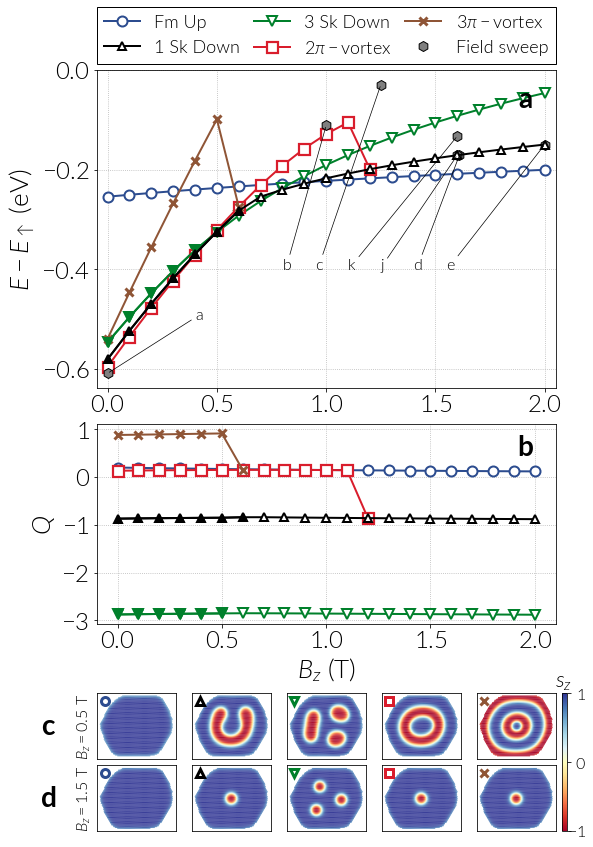

In [31]:
# Each plot has height = 7 (3 rows), the last row of plots has 3.5
f = plt.figure(figsize=(7 * island_ratio, 14))

axs = [None] * 12

# Make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
# Separation of the bottom row of plots from the top grid
outer.update(hspace=0.2)

# Make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=outer[0], hspace=0.45)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[1], hspace=0.1)

# The energy (larger, spanning 3 units) and Q plot (smaller)
axs[0] = plt.subplot(gs1[:3, :])
axs[1] = plt.subplot(gs1[3:, :])

# 
for j, i in enumerate(range(2, 7)):
    axs[i] = plt.subplot(gs2[:1, j:j + 1])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

for j, i in enumerate(range(7, 12)):
    axs[i] = plt.subplot(gs2[1:, j:j + 1])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

    
# -----------------------------------------------------------------------------
# ENERGY AND Q PLOTs

# Plot labels for the 3 X 2 grid of plots
labels = [r'$E - E_{\uparrow}\,\,\mathrm{(eV)}$', # total energy
          r'$Q$',                                                           # Q
          ]

letter_labels = ['a', 'b', 'c']

# Every element of the states[] dictionary is a list with 6 elements:
# [total_E, Q_charge, DMI_E, exchange_E, anisotropy_E, Zeeman_E]
# We plot the topological charge Q (6th element) in the 2nd column of the 1st row
for j, i in enumerate([1, 6]):
    
    ax = axs[j]
    
    # We plot the energies with respect to the ferromagnetic state energy so
    # we substract the zero_st array from the data arrays
    # For Q, we set the zero_st as zeros since we don't need to rescale the
    # topological charge with respect to the FM state
    if i == 6:
        zero_st = np.zeros_like(np.array(states['fm-up'])[:, i])
        scale = 1.
    else:
        scale = C.eV
        zero_st = np.array(sat_up)[:, i] / scale

    ax.set_prop_cycle(cycler('color', d_palette1))

    # Plot the corresponding Q or energy for every magnetic ordering
    ax.plot(np.array(states['1-sk-down'])[:-5, 0], np.array(states['fm-up'])[:-5, i] / scale - zero_st[:-5],
            'o-', label='Fm Up', ms=10, mew=2, markerfacecolor='w')
    ax.plot(np.array(states['1-sk-down'])[:-5, 0], np.array(states['1-sk-down'])[:-5, i] / scale - zero_st[:-5],
            '^-', label='1 Sk Down', ms=8, zorder=5, markerfacecolor='w', mew=2)
    ax.plot(np.array(states['1-sk-down'])[:-5, 0], np.array(states['3-sk-down'])[:-5, i] / scale - zero_st[:-5],
            'v-', label='3 Sk Down', ms=10, mew=2, markerfacecolor='w')
    ax.plot(np.array(states['1-sk-down'])[:-13, 0], np.array(states['tgt-st-up'])[:-13, i] / scale - zero_st[:-13], 
            's-', label=r'$2\pi-\mathrm{vortex}$', markerfacecolor='w', ms=11, mew=2.2)
    # ax.plot(np.array(states['1-sk-up'])[:, 0][12:], np.array(states['helicoid'])[:, 1][12:] / C.meV - zero_st[12:], 'o-', label='Helicoid')
    ax.plot(np.array(states['1-sk-down'])[:, 0][:-19], np.array(states['tgt-st-up-3PI'])[:, i][:-19] / scale - zero_st[:-19], 
            'x-', ms=8, mew=3, label=r'$3\pi-\mathrm{vortex}$')
    
    # Plot the 1-sk or 3-sk again to show the points with worm domains 
    # (elongated/distorted skyrmions). For this we use filled points
    ax.plot(np.array(states['1-sk-down'])[:-19, 0], np.array(states['1-sk-down'])[:-19, i] / scale - zero_st[:-19],
            '^-', ms=8, zorder=5, color=d_palette1[1])
    ax.plot(np.array(states['1-sk-down'])[:-20, 0], np.array(states['3-sk-down'])[:-20, i] / scale - zero_st[:-20],
            'v-', ms=10, color=d_palette1[2])

    # Energy experimental data --------------------------------------------------------
    if i == 1:
        
        ftr = np.logical_and(exp_data[:, 1] > -0.1, exp_data[:, 1] < 2.1)
        ax.plot(exp_data[:, 1][ftr], exp_data[:, 2][ftr], 'h', color='C7', ms=10, mec='k',
                label='Field sweep')
        
        xc1 = 0
        xc2 = 0
        # for j, i in enumerate(exp_data[:, 0].astype(np.int)):
        for k, m in enumerate([0, 1, 2, 10, 9, 3, 4]):

            xy = (exp_data_dict[m][0], exp_data_dict[m][1])

            if xy[0] > 0:
                xyt = (0.8 + 0.15 * xc1, -.4)
                xc1 += 1
            else:
                xyt = (0.4, -.5 - 0.06 * xc2)
                xc2 += 1
                
            # print(m, string.ascii_lowercase[m], xy, xyt)

            ax.annotate(string.ascii_lowercase[m], # Instead of '{:02d}'.format(m), 
                        xy=xy, xytext=xyt,
                        arrowprops=dict(linewidth=0.7, facecolor='black', arrowstyle="-"),
                        fontsize=16, fontweight='light',
                        zorder=999
                        )

        ax.set_xlim(-0.05, 2.05)
        
    # Set ticklables for the Q plot
    if i == 6:
        ax.set_yticks([1, 0, -1, -2, -3])
        ax.set_xlabel(r'$B_{z}\,\,\mathrm{(T)}$')
    
    # *************************************************
    ax.set_ylabel(labels[j])
    ax.grid(ls=':')
    
    if j == 0: 
        ax.legend(ncol=3, loc='lower left',
                  bbox_to_anchor=(0, 1.02, 1.0, 1),
                  mode='expand', borderaxespad=0.,
                  fontsize=18,
                  )
        
    # Alphabet labels to distinguish multiple plots
    ax.text(0.95, 0.95, letter_labels[j], horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes, 
            fontsize=28, fontweight='bold')

# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# Snapshots for the bottom row of plots

marks = ['o', '^', 'v', 's', 'x']
for j, state in enumerate(['fm-up', '1-sk-down', '3-sk-down', 'tgt-st-up', 'tgt-st-up-3PI']):
    ax = axs[2 + j]
    ax.scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=spin_field[state][0][mask], s=1.6, marker='h',  # s = 2 is the limit to visualise hexagons
               cmap='RdYlBu', vmin=-1, vmax=1, edgecolor='None'
               )
    mew = 3
    ax.plot([1.6], [16], marks[j], ms=8, mew=mew, c=d_palette1[j], mfc='w')
    
# -----------------------------------------------------------------------------
# Snapshots for the bottom row of plots

marks = ['o', '^', 'v', 's', 'x']
for j, state in enumerate(['fm-up', '1-sk-down', '3-sk-down', 'tgt-st-up', 'tgt-st-up-3PI']):
    ax = axs[7 + j]
    ax.scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=spin_field[state][1][mask], s=1.6, marker='h',  # s = 2 is the limit to visualise hexagons
               cmap='RdYlBu', vmin=-1, vmax=1, edgecolor='None'
               )
    mew = 3
    ax.plot([1.6], [16], marks[j], ms=8, mew=mew, c=d_palette1[j], mfc='w')
    
# Colorbar --------------------------------------------------------------------
# create color bar next to the last plot of the bottom row, which is the 10th
# axis of the whole grid
box = axs[6].get_position()

axColor = plt.axes([box.x1 + 0.01, box.y0 - box.height - 0.006, 
                    0.01, 2 * box.height + 0.006])
cb = plt.colorbar(axs[10].get_children()[0], cax = axColor, orientation="vertical")
cb.set_ticks([-1, 0, 1])
# Align the colorbar labels to the right:
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, ha='right', fontsize=16)
cb.ax.yaxis.set_tick_params(pad=15)

cb.set_label(r'$s_{z}$', fontsize=22, rotation=0, labelpad=-23, y=1.15)


# Label for the field used for the snapshots, to the left of the first plot
# at the bottom row
axs[2].set_ylabel(r'$B_{z}=0.5\,\,\mathrm{T}$', fontsize=16)
axs[7].set_ylabel(r'$B_{z}=1.5\,\,\mathrm{T}$', fontsize=16)

letter_labels = ['c', 'd']
# Labels for the rows of snapshot plots
for i, ax in enumerate([axs[2], axs[7]]):
    ax.text(-0.7, 0.5, letter_labels[i], horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes, 
            fontsize=28, fontweight='bold')

# ---------------------------------------------------------------------------

# axs[0].set_xlim(0, 2.2)

plt.savefig('image-rotated_hexagonal_island_PdFeIr111_energy-Q_stoppDT1e-7_positive.pdf',
            bbox_inches='tight')

# Mesh

Here we plot the mesh and show the number of spins:

In [271]:
xs, ys = sim.mesh.coordinates[:, 0], sim.mesh.coordinates[:, 1]
x_centre = (xs[mask].max() - xs[mask].min()) * 0.5 + xs[mask].min()
y_centre = (ys[mask].max() - ys[mask].min()) * 0.5 + ys[mask].min()

In [272]:
print('N spins:', len(sim.mu_s[mask]))
print('x-length', xs[mask].max() - xs[mask].min())
print('y-length', ys[mask].max() - ys[mask].min())

N spins: 4509
x-length 20.091
y-length 16.929064593178207


In [81]:
8 * xs[mask].max() / ys[mask].max()

9.467499436847078

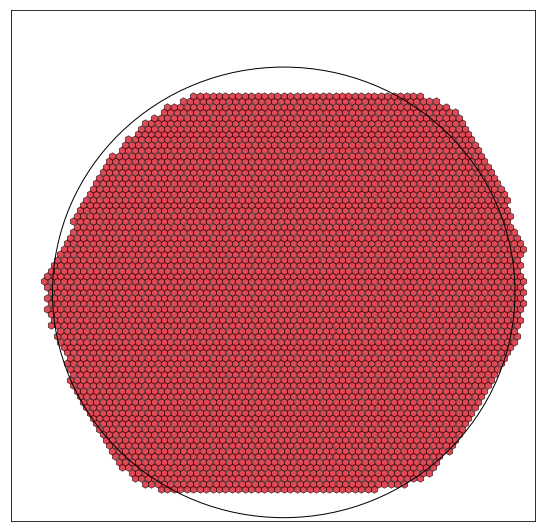

In [273]:
f = plt.figure(figsize=(9.4, 9.4))
ax = f.add_subplot(111)
ax.scatter(sim.mesh.coordinates[:, 0][mask], 
           sim.mesh.coordinates[:, 1][mask],
           color=npt_cm.d_palette1[3],
           s=56, marker='h', linewidth=0.6, edgecolor='k',
           cmap='RdYlBu', vmin=-1, vmax=1,
           alpha=0.8
           )

# ax.scatter(sim.mesh.coordinates[:, 0][mask][rs[mask] < 1.], 
#            sim.mesh.coordinates[:, 1][mask][rs[mask] < 1.],
#            color='b',
#            s=58, marker='h', linewidth=0.6, edgecolor='k',
#            cmap='RdYlBu', vmin=-1, vmax=1,
#            alpha=0.5
#            )

ax.set_yticks(range(0, 16, 5))
# ax.set_yticks([])
# ax.set_ylabel(r'$y\,\,(\mathrm{nm})$')
# ax.set_xlabel(r'$x\,\,(\mathrm{nm})$')

c = circle = plt.Circle((x_centre, y_centre), 9.7, fill='', lw=1, ls='-', color='k')

ax.add_artist(circle)

plt.xlim([-1, 21])
plt.ylim([-1, 21])

plt.xticks([])
plt.yticks([])

# plt.savefig('tmp.pdf', bbox_inches='tight')
plt.savefig('hex_island_image_rotated_atom-mesh.svg', bbox_inches='tight')

Here we compute the critical radius enclosing most of the spins by computing the number of spins left outside the circle and the number of no-spin sites inside the circle. A crossover of these quantities give us a radius approximately containing  the total number of spins:

In [82]:
rs = np.sqrt((xs - x_centre) ** 2 + (ys - y_centre) ** 2)

In [83]:
n_spins = lambda rc: len(xs[mask][rs[mask] <= rc])
n_spins_out = lambda rc: len(xs[rs <= rc]) - n_spins(rc)

n_spins = np.vectorize(n_spins)
n_spins_out = np.vectorize(n_spins_out)

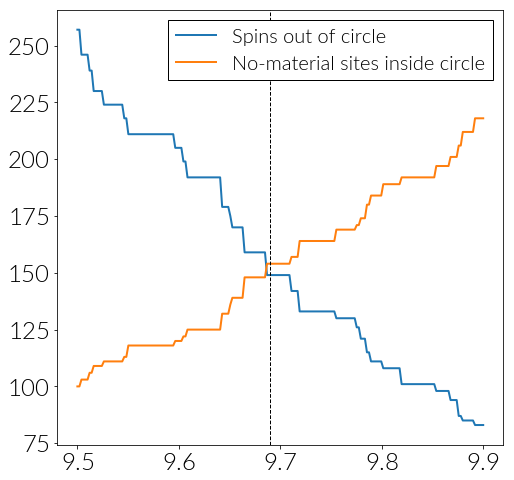

In [87]:
r_max = np.linspace(9.5, 9.9, 200)
plt.plot(r_max, len(xs[mask]) - n_spins(r_max), '-', label='Spins out of circle')
plt.plot(r_max, n_spins_out(r_max), '-', label='No-material sites inside circle')

plt.axvline(x=9.69, c='k', ls='--', lw=1)

plt.legend()

# Profile of 2$\pi$ and $3\pi$ vortices

Plotting the 2$\pi$ and $3\pi$-vortex states in a double plot:

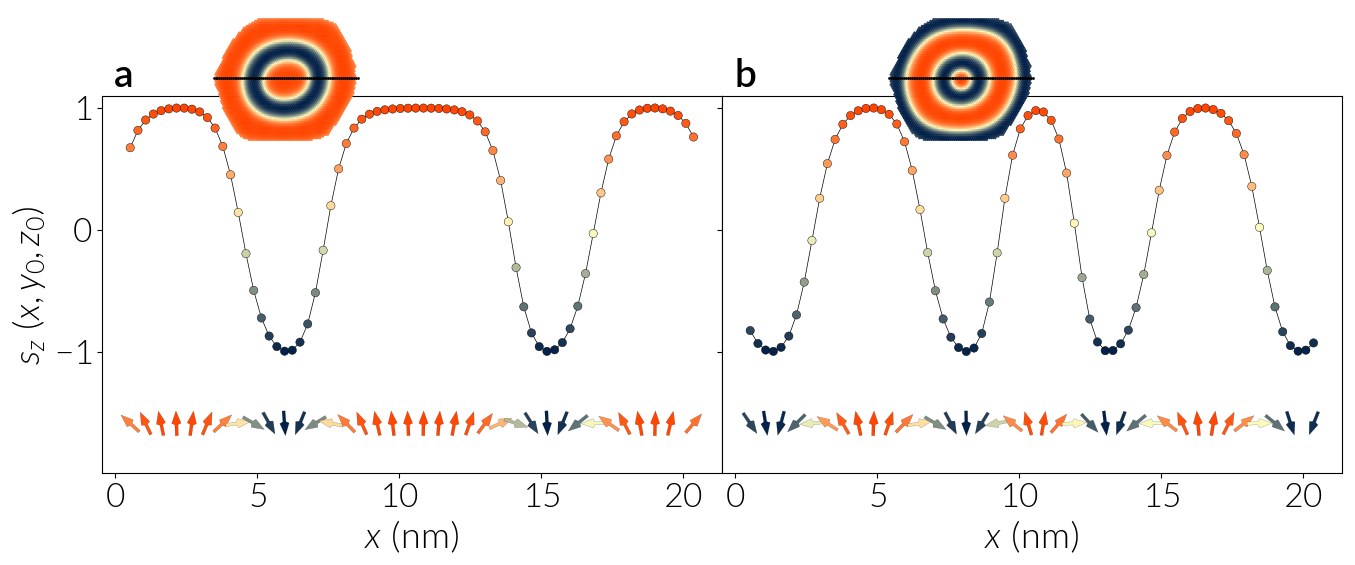

In [87]:
# Define a (2 * 8) width and 8/1.6 height plot
f = plt.figure(figsize=(16, 8/1.6))

# -----------------------------------------------------------------------------
# 2PI vortex

# Create a mask taking the Y coordinates at the middle of the hexagonal island
# To do this we sort the y-coordinates (without repeating) and then get the
# middle value from ys[len(ys) // 2]
# Accordingly, we will use this mask to obtain the coordinates and spins
# from a line at the centre of the sample
ys = sorted(np.unique(sim.mesh.coordinates[:, 1]))
oned_mask = sim.mesh.coordinates[:, 1] == ys[len(ys) // 2]

# Load the magnetisation data from the load_magnetisation_relaxation function
state = 'tgt-st-up'
B = 500
mx = load_magnetisation_relaxation(sim, B * 1e-3, npy_state(state, B), comp='x')
my = load_magnetisation_relaxation(sim, B * 1e-3, npy_state(state, B), comp='y')
mz = load_magnetisation_relaxation(sim, B * 1e-3, npy_state(state, B), comp='z')
# Create masked m arrays and coordinate arrays to avoid plotting lattice
# sites where mu_s = 0
masked_mx = mx[oned_mask][1:-2]
masked_mx[-1] = mx[oned_mask][-3]
masked_mz = mz[oned_mask][1:-2]
masked_mz[-1] = mz[oned_mask][-3]
masked_x = sim.mesh.coordinates[:, 0][oned_mask][1:-2]
masked_x[-1] = sim.mesh.coordinates[:, 0][oned_mask][-3]

# m_z plots using circles:
ax = f.add_subplot(121)
ax.scatter(masked_x, masked_mz,
           c=masked_mz, cmap=npt_cm.BuYlOr_mpl, zorder=2,
           edgecolor='k', lw=0.3
           )
# m_z plot with a line
ax.plot(masked_x, masked_mz, '-k', lw=0.5, zorder=1)
ax.set_ylim([-2, 1.1])
ax.set_yticks([-1, 0, 1])
ax.set_ylabel(r'$s_{z}\,\,(x,y_{0},z_{0})$')
ax.set_xlabel(r'$x\,\,(\mathrm{nm})$')
# ax.set_xlim([-1, 21])

# Create a 1D array of spins using quiver to show the spin orientations
# in the XZ plane

# Manually create an invisible axis in the same range of the m_z plot
iax = f.add_axes([0.125, 0.125, 0.3875, 0.2], frameon=False)

# We will only plot every 2 data points. We manually set the last value since
# spins at the boundary are tilted and is important to show them
masked_mx = mx[oned_mask][1:-2:2]
masked_mx[-1] = mx[oned_mask][-3]
masked_mz = mz[oned_mask][1:-2:2]
masked_mz[-1] = mz[oned_mask][-3]
masked_x = sim.mesh.coordinates[:, 0][oned_mask][1:-2:2]
masked_x[-1] = sim.mesh.coordinates[:, 0][oned_mask][-3]
masked_y = sim.mesh.coordinates[:, 1][oned_mask][1:-2:2]

iax.quiver(masked_x, masked_y,
           masked_mx, masked_mz, masked_mz,
           cmap=npt_cm.BuYlOr_mpl,
           width=0.005, scale=1 / 0.04,
           edgecolor='k', linewidth=0.1, pivot='middle',
           headwidth=3, headlength=4
           )
iax.set_yticks([]), iax.set_xticks([])

# -----------------------------------------------------------------------------
# Snapshot of the 2PI vortex at the top left of the plot

iax3 = f.add_axes([0.19, 0.78, 0.1, 0.265], frameon=False)
iax3.scatter(sim.mesh.coordinates[:, 0][mask], 
             sim.mesh.coordinates[:, 1][mask],
             c=mz[mask], s=.8, marker='h',
             cmap=npt_cm.BuYlOr_mpl, vmin=-1, vmax=1
             )
# Colour the lattice sites at the middle of the stripe, using black
iax3.scatter(sim.mesh.coordinates[:, 0][oned_mask], 
             sim.mesh.coordinates[:, 1][oned_mask],
             # c=mz[oned_mask],
             c='k',
             s=1.2, marker='h',
             vmin=-1, vmax=1
             )

iax3.set_yticks([]), iax3.set_xticks([])

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# 3PI vortex

# Get the mask
ys = sorted(np.unique(sim.mesh.coordinates[:, 1]))
oned_mask = sim.mesh.coordinates[:, 1] == ys[len(ys) // 2]

# Get the data and create masked arrays
state = 'tgt-st-up-3PI'
B = 500
mx = load_magnetisation_relaxation(sim, B * 1e-3, npy_state(state, B), comp='x')
my = load_magnetisation_relaxation(sim, B * 1e-3, npy_state(state, B), comp='y')
mz = load_magnetisation_relaxation(sim, B * 1e-3, npy_state(state, B), comp='z')
masked_mx = mx[oned_mask][1:-2]
masked_mx[-1] = mx[oned_mask][-3]
masked_mz = mz[oned_mask][1:-2]
masked_mz[-1] = mz[oned_mask][-3]
masked_x = sim.mesh.coordinates[:, 0][oned_mask][1:-2]
masked_x[-1] = sim.mesh.coordinates[:, 0][oned_mask][-3]

# m_z plot:
ax2 = f.add_subplot(122, sharey=ax)
ax2.scatter(masked_x, masked_mz,
            c=masked_mz, cmap=npt_cm.BuYlOr_mpl, zorder=2,
            edgecolor='k', lw=0.3
            )
ax2.plot(masked_x, masked_mz, '-k', lw=0.5, zorder=1)
ax2.set_ylim([-2, 1.1])
ax2.set_yticks([-1, 0, 1])
for tk in ax2.get_yticklabels():
    tk.set_visible(False)
ax2.set_xlabel(r'$x\,\,(\mathrm{nm})$')

# Quiver plot at the bottom of the curve:
masked_mx = mx[oned_mask][1:-2:2]
masked_mx[-1] = mx[oned_mask][-3]
masked_mz = mz[oned_mask][1:-2:2]
masked_mz[-1] = mz[oned_mask][-3]
masked_x = sim.mesh.coordinates[:, 0][oned_mask][1:-2:2]
masked_x[-1] = sim.mesh.coordinates[:, 0][oned_mask][-3]
masked_y = sim.mesh.coordinates[:, 1][oned_mask][1:-2:2]

iax2 = f.add_axes([0.5125, 0.125, 0.3875, 0.2], frameon=False)
iax2.quiver(masked_x, masked_y,
            masked_mx, 
            masked_mz,
            masked_mz, cmap=npt_cm.BuYlOr_mpl,
            # scale = 1,
            # headlength=2,
            # headaxislength=0.05,
            width=0.005, scale=1 / 0.04,
            edgecolor='k', linewidth=0.1, pivot='middle',
            headwidth=3, headlength=4
            )
iax2.set_yticks([]), iax2.set_xticks([])

# -----------------------------------------------------------------------------
# Snapshot of the 3PI vortex at the top left

iax4 = f.add_axes([0.612, 0.78, 0.1, 0.265], frameon=False)
iax4.scatter(sim.mesh.coordinates[:, 0][mask], 
             sim.mesh.coordinates[:, 1][mask],
             c=mz[mask], s=.8, marker='h',
             cmap=npt_cm.BuYlOr_mpl, vmin=-1, vmax=1
             )
iax4.scatter(sim.mesh.coordinates[:, 0][oned_mask], 
             sim.mesh.coordinates[:, 1][oned_mask],
             # c=mz[oned_mask],
             c='k',
             s=1.2, marker='h',
             vmin=-1, vmax=1
             )

iax4.set_yticks([]), iax4.set_xticks([])

# -----------------------------------------------------------------------------
# Labels
ax.text(0.02, 1.1, 'a', horizontalalignment='left',
        verticalalignment='top', transform=ax.transAxes, 
        fontsize=28, fontweight='bold')
ax2.text(0.02, 1.1, 'b', horizontalalignment='left',
         verticalalignment='top', transform=ax2.transAxes, 
         fontsize=28, fontweight='bold')

f.subplots_adjust(wspace=0)
plt.savefig('3PI-vortex_2PI-vortex_field_Bz500mT.pdf', bbox_inches='tight')

In [2]:
import numpy as np

In [3]:
4 * np.pi * 2e-12 / 3.9e-3


6.4442926227482935e-09

# Comparison with weak tolerance simulations

In [30]:
states_lowtol = {'1-sk-down': [], 'tgt-st-up': [], 'tgt-st-up-3PI': []}

for s in states_lowtol.keys():
    for B in range(0, 2001, 100):
        total_energy, dmi, exchange, anisotropy, zeeman, Q = load_energy_relaxation(sim, B * 1e-3, npy_state(s, B, base_folder='../simulations/relaxation/image_rotated_B-sweep/npys/'))
        states_lowtol[s].append([B * 1e-3, total_energy, dmi, exchange, anisotropy, zeeman, Q])

/home/david/anaconda3/lib/python3.5/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


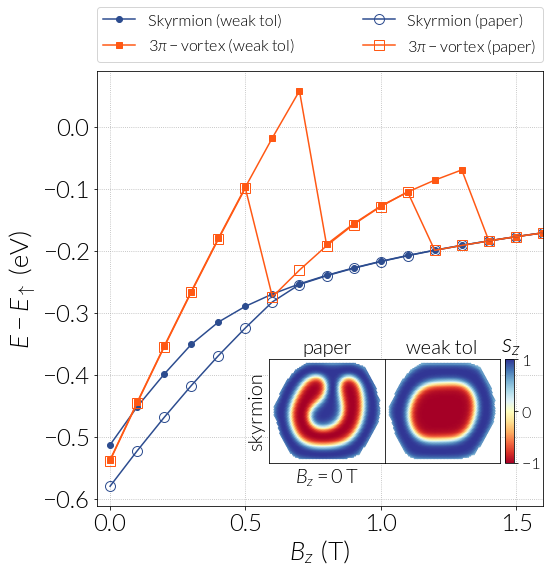

In [108]:
# states_str = ['1-sk-down', 'tgt-st-up']
states_str = ['1-sk-down', 'tgt-st-up-3PI']

marks = ['o', 's', 'h']

f = plt.figure(figsize=(8, 8))
ax = f.add_subplot(111)
ax.set_prop_cycle(cycler('color', d_palette1))

labs = ['Skyrmion', r'$3\pi-\mathrm{vortex}$']

for i, s in enumerate(states_str):
    ax.plot(np.array(states_lowtol[s])[:, 0], 
            (np.array(states_lowtol[s])[:, 1] - np.array(sat_up)[:, 1][:-5]) / C.eV,
            '-', label=labs[i] + ' (weak tol)', marker=marks[i], color=d_palette1[i])

for i, s in enumerate(states_str):
    ax.plot(np.array(states[s])[:-5, 0], 
            (np.array(states[s])[:-5, 1] - np.array(sat_up)[:, 1][:-5]) / C.eV,
            '-', label=labs[i] + ' (paper)', markerfacecolor='None', ms=10, marker=marks[i], color=d_palette1[i])
    
    
# plt.legend(fontsize=22)
ax.legend(ncol=2, loc='lower left',
          bbox_to_anchor=(0, 1.02, 1, 1),
          mode='expand', borderaxespad=0.,
          fontsize=16
          )

plt.grid(ls=':')

plt.xlabel(r'$B_{z}\,\,\mathrm{(T)}$')
plt.ylabel(r'$E -  E_{\uparrow}\,\,\mathrm{(eV)}$')

ax.set_xlim([-0.05, 1.6])


# Inset axes with snapshots of skyrmions
ax = plt.gca()
box = ax.get_position()

axIm = plt.axes([box.x0 + 0.3, 0.2, 0.2, 0.18])
axIm.set_xticks([])
axIm.set_yticks([])
axIm.scatter(sim.mesh.coordinates[:, 0][mask], 
             sim.mesh.coordinates[:, 1][mask],
             c=sfield['1-sk-down'][0][mask], s=2, marker='h',
             cmap='RdYlBu', vmin=-1, vmax=1)
axIm.set_title('paper', fontweight='light', fontsize=20)
axIm.set_xlabel(r'$B_{z}=0\,\mathrm{T}$', fontsize=20)
axIm.set_ylabel('skyrmion', fontsize=20)

axIm = plt.axes([box.x0 + 0.5, 0.2, 0.2, 0.18])
axIm.set_xticks([])
axIm.set_yticks([])
axIm.scatter(sim.mesh.coordinates[:, 0][mask], 
             sim.mesh.coordinates[:, 1][mask],
             c=sfield_lowtol['1-sk-down'][0][mask], s=2, marker='h',
             cmap='RdYlBu', vmin=-1, vmax=1)
axIm.set_title('weak tol', fontweight='light', fontsize=20)

box = axIm.get_position()
axCb = plt.axes([box.x1 + 0.01, box.y0, 0.015, box.height])
cb = matplotlib.colorbar.ColorbarBase(axCb, plt.cm.RdYlBu, orientation="vertical",
                                      ticks=[-1, 0, 1],
                                      norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.set_label(r'$s_{z}$', rotation=0, y=1.25, labelpad=-30)
cb.ax.tick_params(labelsize=16) 

plt.savefig('image-rotated_PdFeIr111_tol-comparison.pdf', bbox_inches='tight')

In [101]:
sfield = {'1-sk-down': {}}
for s in sfield.keys():
    for B in [0, 200]:
        sfield[s][B] = load_magnetisation_relaxation(sim, B * 1e-3, npy_state(s, B))
        
sfield_lowtol = {'1-sk-down': {}}
for s in sfield_lowtol.keys():
    for B in [0, 200]:
        sfield_lowtol[s][B] = load_magnetisation_relaxation(sim, B * 1e-3, npy_state(s, B, base_folder='../simulations/relaxation/image_rotated_B-sweep/npys/'))

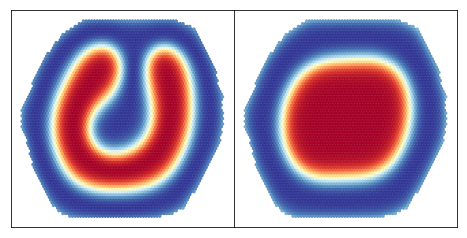

In [102]:
f, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))

axs[0].scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=sfield['1-sk-down'][0][mask], s=7, marker='h',
               cmap='RdYlBu', vmin=-1, vmax=1
               )
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].scatter(sim.mesh.coordinates[:, 0][mask], 
               sim.mesh.coordinates[:, 1][mask],
               c=sfield_lowtol['1-sk-down'][0][mask], s=7, marker='h',
               cmap='RdYlBu', vmin=-1, vmax=1
               )
axs[1].set_xticks([])
axs[1].set_yticks([])

f.subplots_adjust(hspace=0, wspace=0)